# MOM6 ANALYSIS - Eddy Shedding
Here I'm starting the investigation of Eddy Shedding within the EAC Separation region. This is in an effort to present at the PO meeting next week, however I wanted to leave the model evaluation presentation to a future COSIMA meeting rather than the PO Meeting. 

In this notebook I aim to look at the eddy kinetic energy (EKE) in the separation region, and how this might relate to changes in mean kinetic energy (MKE) further north, as well as available potential energy (APE) further north as well. I'd like to look at ways to approximate the eddy energy conversion terms (i.e., barotropic/baroclinic instability pathways) and also consider filtering the data to extract the mesoscale frequencies of interest. 

### 1. Load in data and subset in space around the EAC Separation site

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import glob
import xesmf
import xgcm
from xgcm import Grid

In [3]:
from matplotlib import patches
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [4]:
from xgcm import Grid

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [5]:
# import cartopy to plot maps
import cartopy.crs as ccrs
import cartopy.feature as feature
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m', 
                                       edgecolor='black',
                                       facecolor='gray',
                                       linewidth=0.2)

In [6]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40133,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:32973,Total threads: 1
Dashboard: /proxy/42239/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:35407,


In [7]:
# set paths to model output
## SRM
# eac_003 = '/scratch/v45/jr5971/mom6/archive/eac-003-latest/'
eac_003 = '/scratch/v45/jr5971/mom6-setonix/eac_iaf_003/'
## LRM
sthpac_01 = '/scratch/v45/jr5971/mom6-setonix/sthpac_iaf_01/'
## PARENT
access = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/'
## EAC MOORING 
eac_mooring = '/scratch/v45/jr5971/eac-mooring/'

In [11]:
# import os
# os.chdir('/home/581/jr5971/jr5971/notebooks/')
# # from custom_funcs import *
from myfuncs import *

# Select u,v and subset to same domain as 'eac_eddy' 
eacx_idx = {'W':-215, 'E':-204, 'S':-45, 'N':-28}
eac_mooring = {'lon':[153.771-360, 155.3-360], 'lat':-27.3}
mooring_ext = {'lon':[eac_mooring['lon'][0]-2, eac_mooring['lon'][1]+2], 'lat':-27.3}

## Contents

### 1. ACCESS-OM2 EKE calcs

In [8]:
# get velocities

om2_iaf, _ = open_iaf_global(input_vars=['u','v'],
                             first_year=1990, last_year=2020,
                            decode_times=True)
om2_iaf

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "yu_ocean" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "yu_ocean" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

<xarray.Dataset>
Dimensions:         (xu_ocean: 3600, yu_ocean: 2700, st_ocean: 75,
                     st_edges_ocean: 76, time: 10957, nv: 2)
Coordinates:
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    u               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(31, 19, 300, 300), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bnds       (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    v               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(31, 19, 300, 300), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-u-1-daily-mean-ym_1990_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221019T1337Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

(-225.0, -194.0)

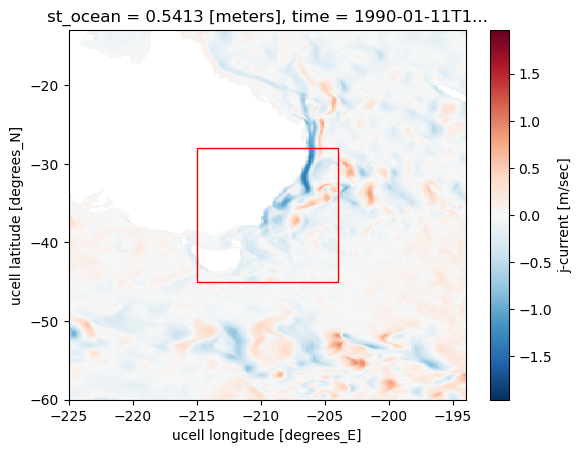

In [9]:
# Select u,v and subset to same domain as 'eac_eddy' 
eacx_idx = {'W':-215, 'E':-204, 'S':-45, 'N':-28}
eac_mooring = {'lon':[153.771-360, 155.3-360], 'lat':-27.3}
mooring_ext = {'lon':[eac_mooring['lon'][0]-2, eac_mooring['lon'][1]+2], 'lat':-27.3}

# Quick plot to show the rough location...
fig, ax = plt.subplots()
om2_iaf['v'].isel(st_ocean=0, time=10).plot(ax=ax)
eacx_box = patches.Rectangle((eacx_idx['W'], eacx_idx['S']), (eacx_idx['E']-eacx_idx['W']),
                             (eacx_idx['N']-eacx_idx['S']), color='r', fill=None)

# array = np.linspace(mooring_ext['lon'][0], mooring_ext['lon'][1], 8)
# ax.scatter(array, [eac_mooring['lat']]*len(array), color='r', marker='o', s=1)

# ax.scatter(x=np.linspace(mooring_ext['lon'][0], mooring_ext['lon'][1], 8),y=mooring_ext['lat']*7, color='r', marker='o', s=1)
# ax.axhline(y=mooring_ext['lat'], xmin=mooring_ext['lon'][0], xmax=mooring_ext['lon'][1], zorder=3, color='r')
ax.add_patch(eacx_box)
ax.set_ylim(eacx_idx['S']-15, eacx_idx['N']+15)
ax.set_xlim(eacx_idx['W']-10, eacx_idx['E']+10)

In [28]:
%%time
# Subset om2 velocities to eacx box 
## Choose just surface values 
# v_om2 = om2_iaf['v'].sel(xu_ocean=slice(eacx_idx['W'], eacx_idx['E']), 
#                          yu_ocean=slice(eacx_idx['S'], eacx_idx['N'])).sel(st_ocean=30, method='nearest')
#                          # st_ocean=slice(0, 500)).sum('st_ocean')#.compute()
u_om2 = om2_iaf['u'].sel(xu_ocean=slice(eacx_idx['W'], eacx_idx['E']), 
                         yu_ocean=slice(eacx_idx['S'], eacx_idx['N'])).sel(st_ocean=30, method='nearest')
                         # st_ocean=slice(0, 500)).sum('st_ocean')#.compute()

CPU times: user 25.4 ms, sys: 12 ms, total: 37.4 ms
Wall time: 49 ms


In [29]:
# Rechunk data
# v_om2_chunked = v_om2.chunk({'time':'auto', 'xu_ocean':-1, 'yu_ocean':-1})
u_om2_chunked = u_om2.chunk({'time':'auto', 'xu_ocean':-1, 'yu_ocean':-1})
u_om2_chunked.data

dask.array<rechunk-merge, shape=(10957, 213, 110), dtype=float32, chunksize=(1426, 213, 110), chunktype=numpy.ndarray>

In [30]:
%%time
# Compute the velocities
u_om2_computed = u_om2_chunked.compute()
# v_om2_computed = v_om2_chunked.compute()

CPU times: user 42.8 s, sys: 1min 1s, total: 1min 44s
Wall time: 3min 16s


In [32]:
u_om2_computed.to_netcdf('/g/data/v45/jr5971/notebooks/data/u_om2_z30_eacx.nc')
# v_om2_computed.to_netcdf('/g/data/v45/jr5971/notebooks/data/v_om2_z30_eacx.nc')

In [33]:
u = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/u_om2_z30_eacx.nc')
# v = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/v_om2_z30_eacx.nc')
u

<xarray.DataArray 'u' (time: 10957, yu_ocean: 213, xu_ocean: 110)>
[256722510 values with dtype=float32]
Coordinates:
  * xu_ocean  (xu_ocean) float64 -215.0 -214.9 -214.8 ... -204.3 -204.2 -204.1
  * yu_ocean  (yu_ocean) float64 -44.93 -44.86 -44.79 ... -28.19 -28.1 -28.01
    st_ocean  float64 ...
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

In [15]:
%%time
# Calculate mean velocities across the eddy box
v_om2_mean = v.mean('time')#.compute()
u_om2_mean = u.mean('time')#.compute()
# Calculate transient velocities
v_om2_transient = v - v_om2_mean
u_om2_transient = u - u_om2_mean

CPU times: user 27.9 s, sys: 43.8 s, total: 1min 11s
Wall time: 55.3 s


In [12]:
# Calculate EKE
EKE_om2 = (0.5 * (u_om2_transient**2 + v_om2_transient**2))#.compute()
EKE_om2

<xarray.DataArray (time: 10957, yu_ocean: 190, xu_ocean: 60)>
array([[[1.07357102e-02, 1.01166200e-02, 9.30453651e-03, ...,
         1.37928296e-02, 1.78901926e-02, 1.86305419e-02],
        [1.03588914e-02, 9.63680167e-03, 8.56501702e-03, ...,
         1.47418510e-02, 1.71798542e-02, 1.71113200e-02],
        [9.56978183e-03, 9.06575844e-03, 7.88485073e-03, ...,
         1.51828052e-02, 1.74985956e-02, 1.75634846e-02],
        ...,
        [           nan,            nan,            nan, ...,
         1.30505323e-05, 9.33804695e-05, 2.42249022e-04],
        [           nan,            nan,            nan, ...,
         3.96744115e-04, 3.55897268e-04, 5.85332164e-04],
        [           nan,            nan,            nan, ...,
         9.33399017e-04, 4.19537188e-04, 1.39373518e-03]],

       [[1.47799496e-02, 1.46280695e-02, 1.35908779e-02, ...,
         6.38618087e-03, 6.62772032e-03, 6.10647444e-03],
        [1.32254753e-02, 1.31477164e-02, 1.23698553e-02, ...,
         7.40314927e-03, 8.17153044e-03, 8.35848041e-03],
        [1.17704272e-02, 1.18223466e-02, 1.11552663e-02, ...,
         9.16144252e-03, 1.06257759e-02, 1.13214888e-02],
...
        [           nan,            nan,            nan, ...,
         8.90704617e-03, 1.91983543e-02, 3.43676694e-02],
        [           nan,            nan,            nan, ...,
         4.60954290e-03, 1.43279703e-02, 2.88370978e-02],
        [           nan,            nan,            nan, ...,
         1.86811027e-03, 1.08409422e-02, 2.35278420e-02]],

       [[9.59638692e-03, 1.96150094e-02, 3.39791253e-02, ...,
         2.36135256e-02, 1.91198010e-02, 1.56867802e-02],
        [9.13627446e-03, 2.04035044e-02, 3.43184508e-02, ...,
         6.84543652e-03, 5.28066605e-03, 6.21922594e-03],
        [2.24146470e-02, 3.47842127e-02, 4.82508764e-02, ...,
         7.34085042e-04, 1.53757317e-03, 4.53768903e-03],
        ...,
        [           nan,            nan,            nan, ...,
         9.55959596e-03, 2.23126300e-02, 4.02230136e-02],
        [           nan,            nan,            nan, ...,
         4.52561118e-03, 1.51695553e-02, 3.16886380e-02],
        [           nan,            nan,            nan, ...,
         1.18671567e-03, 9.94806737e-03, 2.42159721e-02]]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -210.0 -209.9 -209.8 ... -204.3 -204.2 -204.1
  * yu_ocean  (yu_ocean) float64 -39.99 -39.91 -39.84 ... -24.24 -24.15 -24.06
    st_ocean  float64 29.45
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00

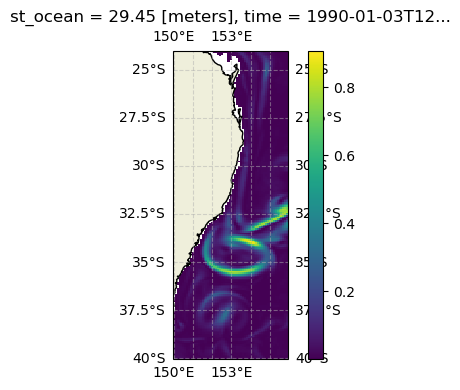

In [37]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))

EKE_om2.isel(time=2).plot(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')


In [34]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [39]:
def plot_eac_eke(i):
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))
    EKE_om2.isel(time=i).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
    ax.add_feature(cfeature.LAND)
    ax.coastlines()
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

In [40]:
interact(plot_eac_eke, i=(0, len(EKE_om2.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_eke(i)>

It would be great to make an interactive plot of the above, along with the relative vorticity. Below is parts of the example notebook from COSIMA written for the relative vorticity calculation in MOM5

### Vorticity Calculation

In [35]:
# Parameters used for computing quantities
Omega = 7.292e-5 # Earth's rotation rate in radian/s
Rearth = 6371.e3 # Earth's radius in m

In [36]:
lon = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output000/ocean/ocean-2d-geolon_c.nc')['geolon_c']
lat = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output000/ocean/ocean-2d-geolat_c.nc')['geolat_c']
lon

<xarray.DataArray 'geolon_c' (yu_ocean: 2700, xu_ocean: 3600)>
[9720000 values with dtype=float32]
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
    geolon_c  (yu_ocean, xu_ocean) float32 ...
Attributes:
    long_name:     uv longitude
    units:         degrees_E
    valid_range:   [-281.  361.]
    cell_methods:  time: point

In [37]:
# Calculate the Coriolis parameter f = 2*Omega*sin(lat)
f = 2 * Omega * np.sin(np.deg2rad(lat))
f.attrs['long_name'] = 'Coriolis Parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'

In [38]:
folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')
grid.data_vars

Data variables:
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    drag_coeff  (time, yu_ocean, x

In [39]:
# Get the grid variables from the most recent OM2 experiment
## create list of variable names from older grid
grid_vars=list(grid.data_vars)
## Create empty list to store variable pathnames
grid_file_ls = []
## Loop through grid-variable names, find path, and append to empty list
for var in grid_vars:
    pattern = f'{access}/output150/ocean/*{var}*.nc'
    matches = glob.glob(pattern)
    grid_file_ls.extend(matches)
# Open an xr.Dataset with all grid variables
grid = xr.open_mfdataset(grid_file_ls)
# Cut down to eddy box
grid = grid.sel(xt_ocean=slice(eacx_idx['W'], eacx_idx['E']), 
                xu_ocean=slice(eacx_idx['W'], eacx_idx['E']),
                yt_ocean=slice(eacx_idx['S'], eacx_idx['N']),
                yu_ocean=slice(eacx_idx['S'], eacx_idx['N']))

grid

<xarray.Dataset>
Dimensions:     (xt_ocean: 110, yt_ocean: 213, time: 2, xu_ocean: 110,
                 yu_ocean: 213)
Coordinates:
  * xt_ocean    (xt_ocean) float64 -214.9 -214.8 -214.7 ... -204.2 -204.1 -204.0
  * yt_ocean    (yt_ocean) float64 -44.97 -44.89 -44.82 ... -28.23 -28.14 -28.06
  * time        (time) datetime64[ns] 1900-01-01 1995-10-01
  * xu_ocean    (xu_ocean) float64 -215.0 -214.9 -214.8 ... -204.3 -204.2 -204.1
  * yu_ocean    (yu_ocean) float64 -44.93 -44.86 -44.79 ... -28.19 -28.1 -28.01
Data variables:
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(213, 70), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(213, 71), meta=np.ndarray>
    drag_coeff  (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(2, 213, 71), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(213, 70), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(213, 71), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(213, 70), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(213, 71), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(213, 70), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(213, 71), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(213, 70), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(213, 71), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-area_t.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221028T0304Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [43]:
# u_snap = u.isel(time=0)
# v_snap = v.isel(time=0)
# Create new dataset that has both velocity components and grid information
ds = xr.merge([u, v, grid])
# Update coordinate attributes
ds.coords['xt_ocean'].attrs.update(axis='X')
# Shift the corner (u) point 0.5 to the right of t-cell axis
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=False)

Then, `xgcm` gives you a way to interpolate between grids (with the `.interp` function) and a way to compute differences (`.diff` function). For example, the expression $v(i,j,k) - v(i-1,j,k)$ is obtained via `grid.diff(ds.v, 'X')`.

Using `xgcm`'s functionality we can replicate the MOM5 vertical vorticity computation as:

In [44]:
%%time
zeta_xgcm = ( grid.interp( grid.diff(ds.v, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
             - grid.interp( grid.diff(ds.u, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )


CPU times: user 3.1 s, sys: 4.38 s, total: 7.48 s
Wall time: 5.7 s


In [45]:
%%time
zeta_xgcm = zeta_xgcm.compute()

2023-12-06 15:32:09,946 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.60 GiB -- Worker memory limit: 4.00 GiB
2023-12-06 15:32:18,595 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.78 GiB -- Worker memory limit: 4.00 GiB
2023-12-06 15:32:19,263 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 3.33 GiB -- Worker memory limit: 4.00 GiB
2023-12-06 15:32:20,344 - distributed.worker.memory - WARNING - Worker is at 74% memory usage. Resuming worker. Process memo

CPU times: user 25.4 s, sys: 31.8 s, total: 57.1 s
Wall time: 1min 32s


In [51]:
zeta_xgcm = zeta_xgcm[1:]
zeta_xgcm

<xarray.DataArray (time: 10958, yt_ocean: 213, xt_ocean: 110)>
array([[[-2.57008141e-05,  3.84821578e-06,  4.21852292e-06, ...,
         -2.13681119e-06, -4.85511555e-06, -5.55257520e-06],
        [-2.71481404e-05,  5.72896897e-06,  5.97248709e-06, ...,
         -2.72912121e-06, -7.00192504e-06, -8.45955947e-06],
        [-3.00732081e-05,  7.36825223e-06,  6.75595402e-06, ...,
         -1.56674764e-06, -7.13935424e-06, -9.44617568e-06],
        ...,
        [            nan,             nan,             nan, ...,
          6.47485194e-06,  4.61497575e-06,             nan],
        [            nan,             nan,             nan, ...,
          5.69663825e-06,  1.78871619e-06,             nan],
        [            nan,             nan,             nan, ...,
          4.05686023e-06,  2.26081141e-07,             nan]],

       [[-9.37600817e-06,  3.20230993e-06,  4.15657223e-06, ...,
         -2.45818683e-06, -3.74272781e-06, -4.15049089e-06],
        [-9.70141627e-06,  6.10325924e-06,  5.85672024e-06, ...,
         -1.93330402e-06, -4.77814865e-06, -6.25431494e-06],
        [-1.16609754e-05,  9.45178544e-06,  8.08073310e-06, ...,
         -8.19379579e-07, -5.74837122e-06, -8.24132439e-06],
...
          1.09373184e-06,  1.44293585e-06,             nan],
        [            nan,             nan,             nan, ...,
         -2.93483936e-06, -1.18717605e-06,             nan],
        [            nan,             nan,             nan, ...,
         -1.13192823e-06, -1.30755765e-07,             nan]],

       [[-1.09234970e-05,  1.57755539e-06,  4.89394097e-06, ...,
         -3.13311421e-06, -4.81520601e-07, -4.66573312e-07],
        [-4.71704698e-06,  1.80477800e-05,  2.46116961e-05, ...,
         -4.24191649e-06, -1.74514321e-06, -1.28893021e-06],
        [-1.60454820e-05,  4.18660238e-06,  1.52211978e-05, ...,
         -6.78631477e-06, -4.59906005e-06, -2.64683058e-06],
        ...,
        [            nan,             nan,             nan, ...,
          1.51015570e-06,  1.00897159e-06,             nan],
        [            nan,             nan,             nan, ...,
         -7.57251655e-07,  3.10671396e-07,             nan],
        [            nan,             nan,             nan, ...,
         -1.13640328e-06, -1.17486266e-07,             nan]]],
      dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00
  * xt_ocean  (xt_ocean) float64 -214.9 -214.8 -214.7 ... -204.2 -204.1 -204.0
  * yt_ocean  (yt_ocean) float64 -44.97 -44.89 -44.82 ... -28.23 -28.14 -28.06

### Plotting

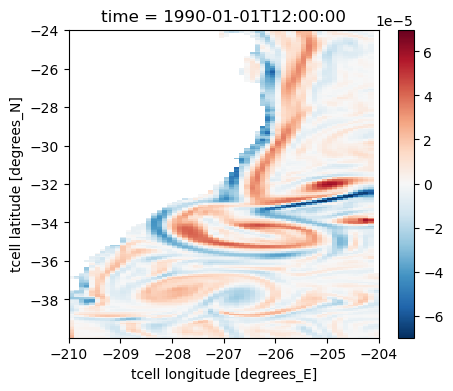

In [25]:
plt.figure(figsize=(5,4))
zeta_xgcm.isel(time=1).plot()

Right, so now that I can calculate both EKE and relative vorticity, let's plot these next to each other and make it Interactive...

In [52]:
maxvalue = 8e-5

In [44]:
def plot_eac_eke(i):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
    
    # ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))
    EKE_om2.isel(time=i).plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
    ax1.add_feature(cfeature.LAND)
    ax1.coastlines()
    ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    zeta_xgcm.isel(time=i).plot.contour(ax=ax2, transform=ccrs.PlateCarree(), vmin=-maxvalue, vmax=maxvalue, cmap=cm.cm.balance)
    ax2.add_feature(cfeature.LAND)
    ax2.coastlines()
    ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

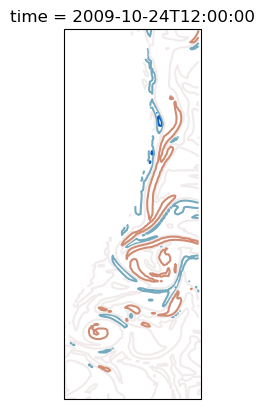

In [43]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
zeta_xgcm.isel(time=7238).plot.contour(transform=ccrs.PlateCarree(), vmin=-maxvalue, vmax=maxvalue, cmap=cm.cm.balance)


In [45]:
interact(plot_eac_eke, i=(0, len(EKE_om2.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_eke(i)>

What I'd like to do now is - have a third plot of temperature shading and streamlines for the velocity...

### Temperature and velocity streamlines

In [9]:
%%time
# Load in the temperature data from ACCESS
om2_iaf, _ = open_iaf_global(input_vars=['temp'],
                             first_year=1990, last_year=2020,
                            decode_times=True)
om2_iaf

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

CPU times: user 26.2 s, sys: 5.7 s, total: 31.9 s
Wall time: 1min 34s


<xarray.Dataset>
Dimensions:         (xt_ocean: 3600, yt_ocean: 2700, st_ocean: 75,
                     st_edges_ocean: 76, time: 10957, nv: 2)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(31, 19, 300, 300), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bnds       (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1990_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221019T1326Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [12]:
# Subset down to eddy box
om2_temp = om2_iaf['temp'].sel(xt_ocean=slice(eacx_idx['W'], eacx_idx['E']),
                               yt_ocean=slice(eacx_idx['S'], eacx_idx['N'])).sel(st_ocean=30, method='nearest').chunk({'xt_ocean':-1, 'yt_ocean':-1})
om2_temp

<xarray.DataArray 'temp' (time: 10957, yt_ocean: 213, xt_ocean: 110)>
dask.array<rechunk-merge, shape=(10957, 213, 110), dtype=float32, chunksize=(31, 213, 110), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -214.9 -214.8 -214.7 ... -204.2 -204.1 -204.0
  * yt_ocean  (yt_ocean) float64 -44.97 -44.89 -44.82 ... -28.23 -28.14 -28.06
    st_ocean  float64 29.45
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature

In [13]:
%%time
om2_temp = om2_temp - 273.15
om2_temp = om2_temp.compute()

CPU times: user 37.4 s, sys: 5.43 s, total: 42.8 s
Wall time: 1min 33s


In [14]:
om2_temp.to_netcdf('/g/data/v45/jr5971/notebooks/data/temp_om2_z30_eacx.nc')

In [ ]:
%%time
om2_temp = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/temp_om2_z30_eacx.nc')

CPU times: user 25.7 ms, sys: 11.5 ms, total: 37.3 ms
Wall time: 39.9 ms


#### Prepare data for streamplot
Here, it should be a lot easier to prepare the velocity data for ACCESS on the B-Grid compared to MOM6 on the C-grid. 

In [ ]:
# define resolution of new target grid
res = 1 # 2 equals half the resolution of native grid
# Rename coords to lon/lat
u = u.rename({'xu_ocean':'lon', 'yu_ocean':'lat'})
v = v.rename({'xu_ocean':'lon', 'yu_ocean':'lat'})

# Create target grid with equal spaced points
x_target = np.linspace(u['lon'].min(), u['lon'].max(), int(len(u['lon']) / res))
y_target = np.linspace(u['lat'].min(), u['lat'].max(), int(len(u['lat']) / res))
X_target, Y_target = np.meshgrid(x_target, y_target)

# Create regridder object
regridder = xesmf.Regridder(u, {'lon':X_target, 'lat':Y_target}, 'bilinear')

# regrid data
u_target = regridder(u)
v_target = regridder(v)

In [ ]:
# Regrid temperature to be plotted
# om2_temp = om2_temp.rename({'xt_ocean':'lon', 'yt_ocean':'lat'})
# x_t = np.linspace(om2_temp['lon'].min(), om2_temp['lon'].max(), 
#                   int(len(om2_temp['lon'])/2))
# y_t = np.linspace(om2_temp['lat'].min(), om2_temp['lat'].max(),
#                   int(len(om2_temp['lat'])/2))
# X_t, Y_t = np.meshgrid(x_t, y_t)


In [71]:
print(f'x_target shape: {x_target.shape}')
print(f'u shape: {u.shape}')

x_target shape: (30,)
u shape: (10957, 190, 60)


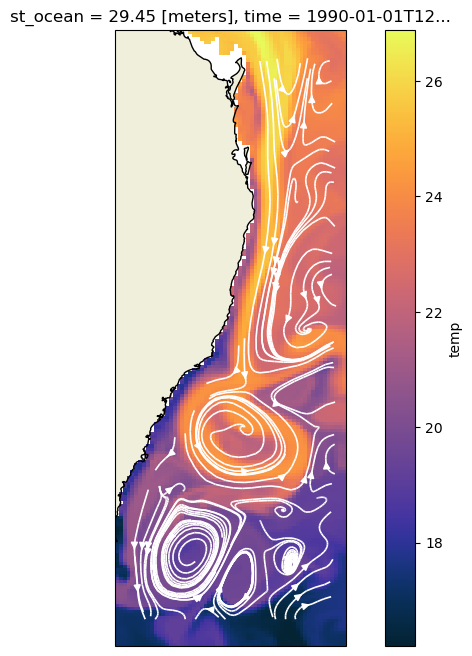

In [ ]:
# Plot temperature and streamlines
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
om2_temp.isel(time=0).plot(ax=ax, cmap=cm.cm.thermal, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.streamplot(x_target, y_target, u_target.isel(time=0), v_target.isel(time=0), density=.8, color='w', transform=ccrs.PlateCarree(), 
              linewidth=1.2, broken_streamlines=False)
ax.coastlines()

In [ ]:
def plot_eac_eke(i):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})

    # ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))
    EKE_om2.isel(time=i).plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
    ax1.add_feature(cfeature.LAND)
    ax1.coastlines()
    ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    ax1.set_title(f'EKE, Time: {str(EKE_om2.isel(time=i).time.values)[:10]}')
    zeta_xgcm.isel(time=i).plot.contour(ax=ax2, transform=ccrs.PlateCarree(), vmin=-maxvalue, vmax=maxvalue, cmap=cm.cm.balance)
    ax2.add_feature(cfeature.LAND)
    ax2.coastlines()
    ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    ax2.set_title(f'$\zeta$, Time: {str(zeta_xgcm.isel(time=i).time.values)[:10]}')

    om2_temp.isel(time=i).plot(ax=ax3, transform=ccrs.PlateCarree(), cmap=cm.cm.thermal)
    ax3.add_feature(cfeature.LAND)
    ax3.coastlines()
    ax3.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    ax3.set_title(f'Temp, Time: {str(om2_temp.isel(time=i).time.values)[:10]}')


In [ ]:
interact(plot_eac_eke, i=(0, len(EKE_om2.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_eke(i)>

Now, above we are plotting the vorticity along with the temperature. The next step (pending everything looks good) is to run the MHW analysis on the new area and make new plots with that data. 

Then with that data, we can recreate those same plots as before. 
* Run MHW analysis on new temperature data
* Make some exploratory plots of the vorticity/mhw output to find a good event to animate. 
    * Here we are looking for an eddy shedding event that brings a MHW poleward and hopefully reaches Tasmania. 
* Decide on dates, then make an animation of this event. Hopefully by using the ArtistAnimation, we can make a plot with the streamlines.